# Recognizing handwritten signatures
We hope to distinguish between real and forged signatures

In [1]:
# import required modules, packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.svm import SVC
%matplotlib inline

# import datasets, classifiers, performance metrics
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

In [2]:
# accessing the dataset
from PIL import Image, ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

p = Path("sample_Signature/")
dirs = p.glob("*")
labels_dict = {'forge':0, 'genuin':1}

image_data = []
labels = []

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1][:-1]

    for img_path in folder_dir.glob("*.png"):
        # reading/opens each image
        img = Image.open(img_path)
        if 'L' in img.getbands():  # image is black-and-white, colorize it
            img = ImageOps.colorize(img, black="blue", white="white")
        # resizing each image
        img_new = img.resize((200,200))
        # convert each image to array using numpy
        img_array = np.asarray(img_new)
        # append each image array to image_data list
        image_data.append(img_array)
        # match the label to corresponding image
        labels.append(labels_dict[label])

        # image color inversion
        from skimage import util
        import numpy as np
        color_inversion_img = util.invert(img_array)
        # alternate method with numpy
        #color_inversion_img_w_np = np.invert(img)
        img_invert_array = np.asarray(color_inversion_img)
        # append each image array to image_data list
        image_data.append(img_invert_array)
        # match the label to corresponding image
        labels.append(labels_dict[label])

In [3]:
print(len(image_data))
print(len(labels))

600
600


In [4]:
image_data = np.array(image_data, dtype = 'float32')/255.0
labels = np.array(labels)

print(image_data.shape, labels.shape)

(600, 200, 200, 3) (600,)


In [5]:
import random 
combined = list(zip(image_data, labels))
random.shuffle(combined)

image_data[:], labels[:] = zip(*combined)

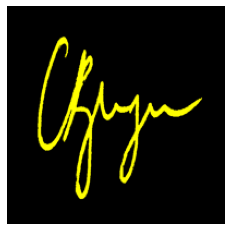

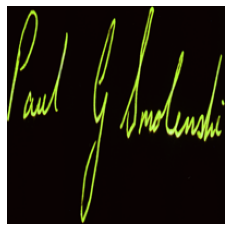

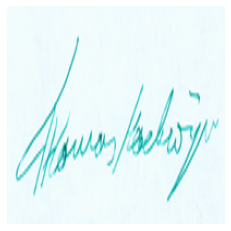

In [6]:
def drawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

# example visualizations
for i in range(3):
    drawImg(image_data[i])

# Keras Classification

In [7]:
# to use a classifier, first need to flatten images, convert to grayscale

# flatten images
n_samples = len(image_data)
data = image_data.reshape((n_samples, -1))

# split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size =0.5, shuffle = False)

In [8]:
X_train.shape

(300, 120000)

In [9]:
X_train[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [10]:
model = keras.Sequential([
    keras.layers.Dense(2, input_shape=(120000,), activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

model.fit(X_train,y_train, epochs = 10)

Epoch 1/10
10/10 [==============================] - 0s 9ms/step - loss: 21.1840 - accuracy: 0.4967
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 13.8435 - accuracy: 0.5033
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 17.7739 - accuracy: 0.4567
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 16.0890 - accuracy: 0.5133
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 22.8994 - accuracy: 0.5100
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 15.7266 - accuracy: 0.5233
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 18.0257 - accuracy: 0.5433
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: 18.4886 - accuracy: 0.5467
Epoch 9/10
10/10 [==============================] - 0s 9ms/step - loss: 18.6815 - accuracy: 0.5233
Epoch 10/10
10/10 [==============================] - 0s 7ms/step - loss: 7.9984 - accuracy: 0.6233


In [11]:
model.evaluate (X_test, y_test)

10/10 [==============================] - 0s 4ms/step - loss: 6.4841 - accuracy: 0.5267


[6.484058856964111, 0.5266666412353516]

# Serialization


In [12]:
# check if a model has already been saved and if it hasn't, save it to the disk
# this is basically the serialization
'''import os.path
if os.path.isfile('models/Real_Forged_signatures.h5') is False:
    model.save('models/Real_Forged_signatures.h5')
    '''
json_string = model.to_json()

In [13]:
import json

# writing to json file
with open("2021-09-06-keras.json", "w") as my_file:
    json_object = json.dump(json_string, my_file)

# previewing content
json_str = json.dumps(json_string)
print(json_str)

"{\"class_name\": \"Sequential\", \"config\": {\"name\": \"sequential\", \"layers\": [{\"class_name\": \"InputLayer\", \"config\": {\"batch_input_shape\": [null, 120000], \"dtype\": \"float32\", \"sparse\": false, \"ragged\": false, \"name\": \"dense_input\"}}, {\"class_name\": \"Dense\", \"config\": {\"name\": \"dense\", \"trainable\": true, \"batch_input_shape\": [null, 120000], \"dtype\": \"float32\", \"units\": 2, \"activation\": \"sigmoid\", \"use_bias\": true, \"kernel_initializer\": {\"class_name\": \"GlorotUniform\", \"config\": {\"seed\": null}}, \"bias_initializer\": {\"class_name\": \"Zeros\", \"config\": {}}, \"kernel_regularizer\": null, \"bias_regularizer\": null, \"activity_regularizer\": null, \"kernel_constraint\": null, \"bias_constraint\": null}}]}, \"keras_version\": \"2.6.0\", \"backend\": \"tensorflow\"}"


# Deserialization

In [14]:
# Deserialization
#from tensorflow.keras.models import model_from_json
#model_architecture = model_from_json(json_string)

with open("2021-09-06-keras.json", "r") as my_file_read:
    my_list = json.load(my_file_read)

print(my_list)

{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 120000], "dtype": "float32", "sparse": false, "ragged": false, "name": "dense_input"}}, {"class_name": "Dense", "config": {"name": "dense", "trainable": true, "batch_input_shape": [null, 120000], "dtype": "float32", "units": 2, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}]}, "keras_version": "2.6.0", "backend": "tensorflow"}
